In [1289]:
import pandas as pd
import numpy as np
import plotly.express as px
from tqdm import tqdm

In [2]:
df = pd.read_csv('rio-2016-athletes.csv')
df['m/kg'] = df['height (m)']/df['weight (kg)']
df['kg/m'] = df['weight (kg)']/df['height (m)']

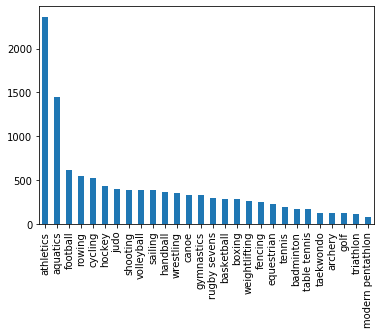

In [1373]:
df['sport'].value_counts().plot.bar()

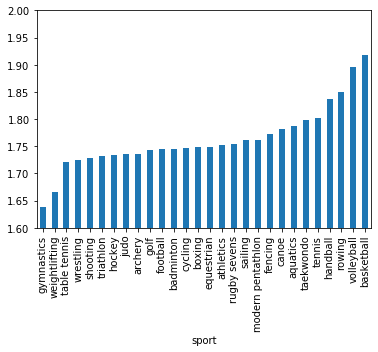

In [1288]:
df.groupby('sport')['height (m)'].mean().sort_values().plot.bar(ylim=(1.6,2))

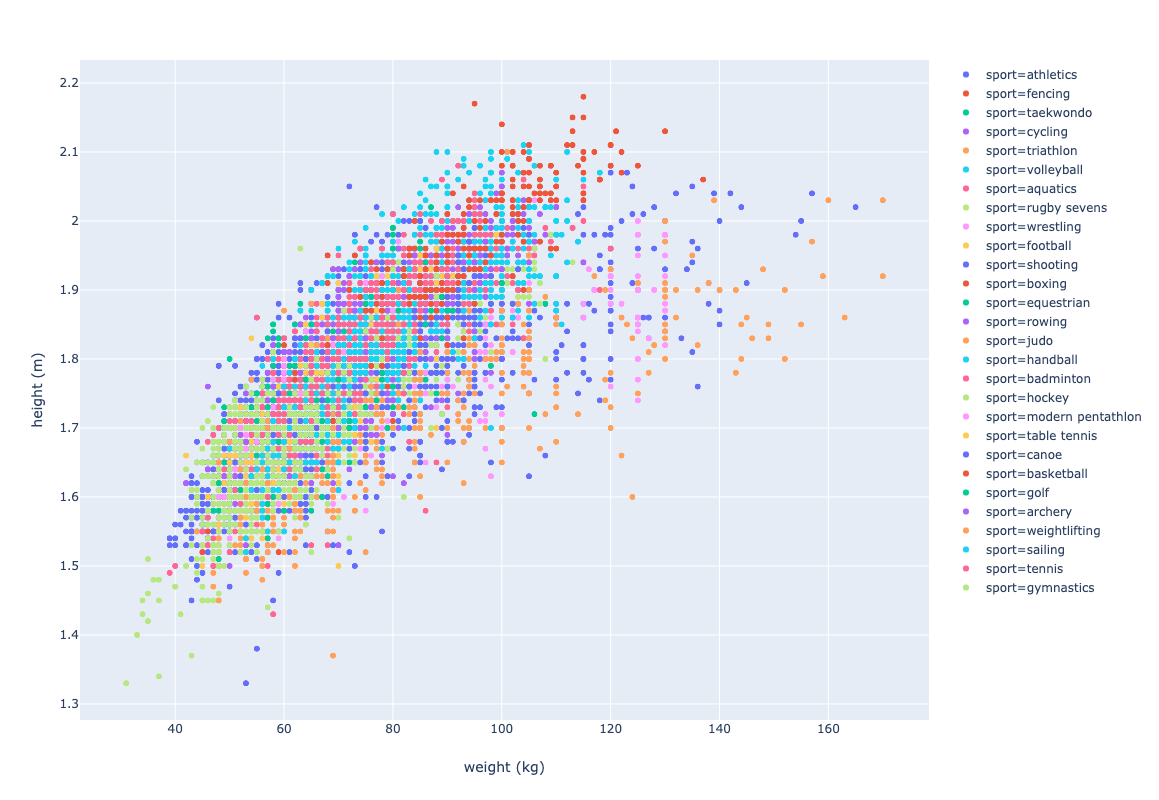

In [4]:
import plotly.express as px
px.scatter(df,y='height (m)',x='weight (kg)',color='sport',height=800,width=1000)

# Get df_plot

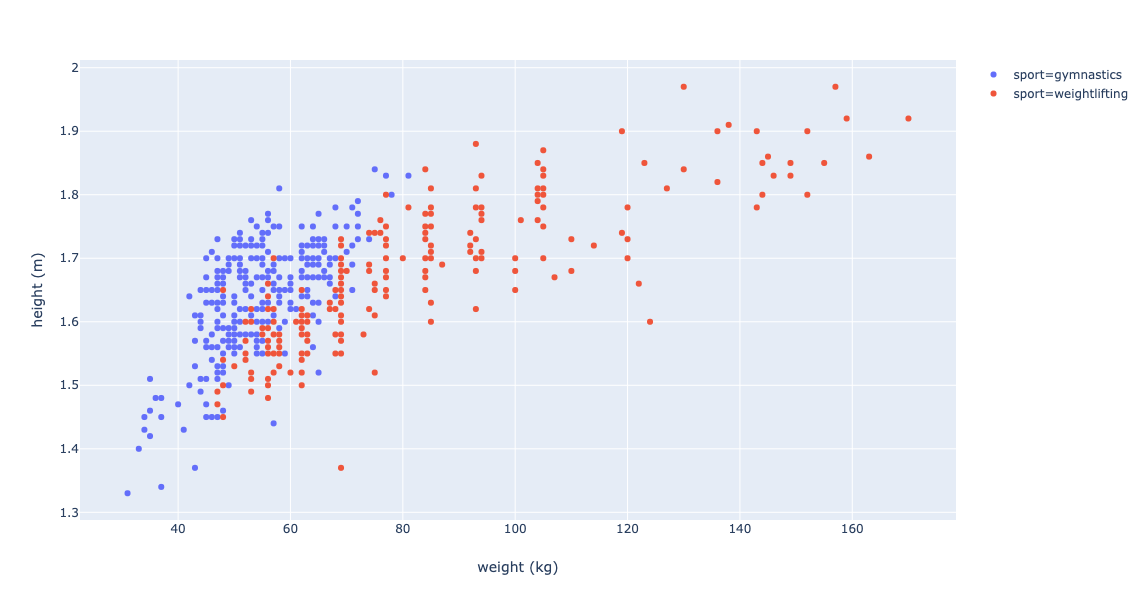

In [1290]:
df_plot = df[ df['sport'].isin({'weightlifting','gymnastics'}) ] #,'weightlifting'}) ]
df_plot = df_plot.groupby(['height (m)','weight (kg)'])['sport'].first().reset_index()
px.scatter(df_plot,y='height (m)',x='weight (kg)',color='sport',height=600,width=700)

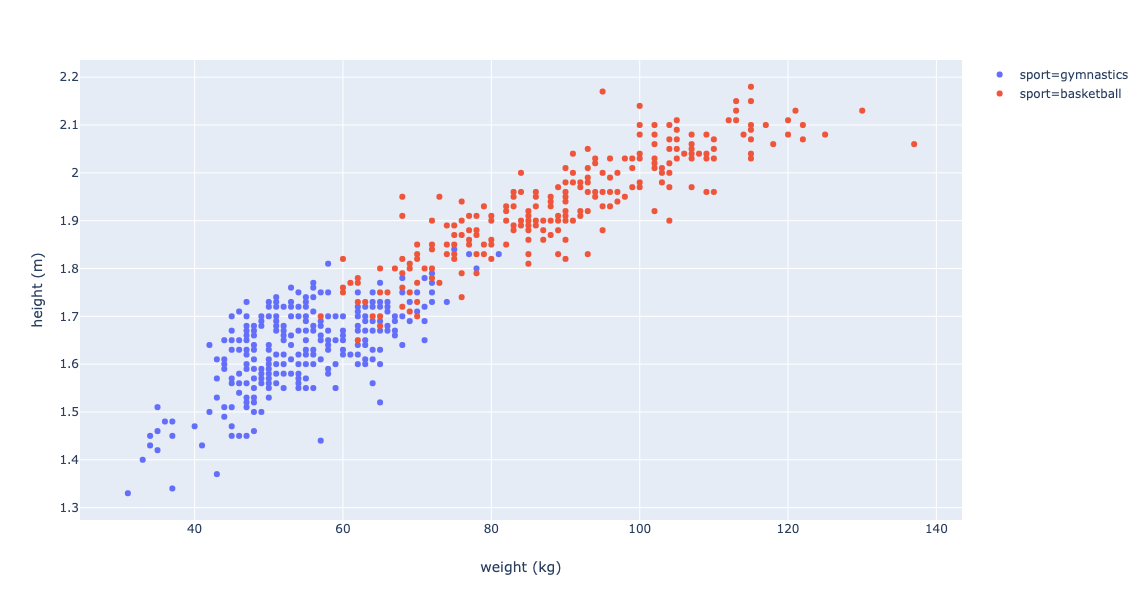

In [1308]:
import plotly.express as px
df_plot = df[ df['sport'].isin({'basketball','gymnastics'}) ] #,'weightlifting'}) ]
df_plot = df_plot.groupby(['height (m)','weight (kg)'])['sport'].first().reset_index()
px.scatter(df_plot,y='height (m)',x='weight (kg)',color='sport',height=600,width=700)

In [1309]:
X = df_plot[['height (m)','weight (kg)']].values
Y = df_plot['sport'].values

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.7)

X_ = X - np.mean(X,0)[None,:]
X_ = X_ / np.std(X,0)[None,:]
Y_ = (Y == 'gymnastics').astype(int)

# Man+Machine

In [1313]:
heights = sorted(set(df_plot['height (m)']))
weights = sorted(set(df_plot['weight (kg)']))

In [1339]:
best_accuracy = 0
for height in tqdm(heights):
    Y_pred = df_plot['height (m)'] <= height
    accuracy = float(np.mean( Y_pred == Y_ ))
    if accuracy < best_accuracy:
        continue
    best_accuracy = accuracy
    height_thres = height
print(best_accuracy,height_thres)

100%|██████████| 79/79 [00:00<00:00, 575.62it/s]

0.9373649954795837 1.76


In [1342]:
best_accuracy = 0
for height in tqdm(heights):
    for weight in weights:
        Y_pred = ( df_plot['height (m)'] <= height ) & ( df_plot['weight (kg)'] <= weight )        
        accuracy = float(np.mean( Y_pred == Y_ ))
        if accuracy < best_accuracy:
            continue
        best_accuracy = accuracy
        height_thres, weight_thres = height, weight
print(best_accuracy)

100%|██████████| 79/79 [00:10<00:00,  7.71it/s]

0.9395248293876648


In [ ]:
correct_pay = 1000
human_pay = -5000
best_pay = 0
for height in tqdm(heights):
    for weight in tqdm(weights):
        for height_ in heights:
            for weight_ in weights:
                if weight_ <= weight or height_ <= height:
                    continue
                Y_pred = ( ( X[:,0] <= height  ) & ( X[:,1] <= weight  ) )*0.5 +\
                         ( ( X[:,0] <= height_ ) & ( X[:,1] <= weight_ ) )*0.5
                pay = ( ( Y_pred == 0.5 )*human_pay ).sum() + ( ( np.abs( Y_pred - Y_ ) == 0 )*correct_pay ).sum()
                accuracy = float(np.mean( Y_pred == Y_ ))
                if pay < best_pay:
                    continue
                best_pay = pay
                height_thres, weight_thres = height, weight
print(best_pay)

# Get Training Data

In [903]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [216]:
train_accs = list()
test_accs = list()
from sklearn.metrics import accuracy_score

train_accs = list()
test_accs = list()
K = list(range(2,30))
for k in tqdm(K):
    #mod = DecisionTreeClassifier(max_depth=10)
    mod = RandomForestClassifier(n_estimators=1,max_leaf_nodes=k)
    k_train_accs = list()
    k_test_accs = list()
    for _ in range(1000):
        #result = cross_validate(mod,X,Y,cv=100,scoring='accuracy',return_train_score=True)
        #test_acc = np.mean(result['test_score'])
        #train_acc = np.mean(result['train_score'])
        X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.5)
        mod.fit(X_train,Y_train)
        Y_train_pred = mod.predict(X_train)
        Y_test_pred = mod.predict(X_test)
        train_acc = np.mean( Y_train_pred == Y_train )
        test_acc = np.mean( Y_test_pred == Y_test )
        k_train_accs.append(train_acc)
        k_test_accs.append(test_acc)
    train_accs.append(np.mean(k_train_accs))
    test_accs.append(np.mean(k_test_accs))


100%|██████████| 28/28 [01:01<00:00,  2.21s/it]


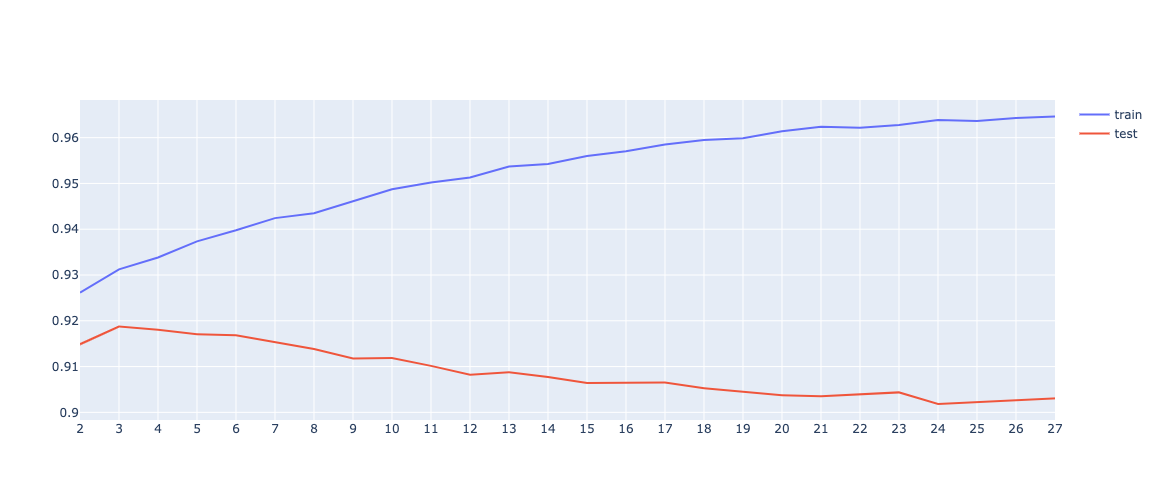

In [217]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=K, y=train_accs,
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=K, y=test_accs,
                    mode='lines',
                    name='test'))
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis={'type':'category'},

)

fig.show()

In [848]:
mod = RandomForestClassifier(n_estimators=1,max_leaf_nodes=3)
mod.fit(X,Y)
np.mean(mod.predict(X) == Y)

DeviceArray(0.93088555, dtype=float32)

# Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
mod = LogisticRegression(solver='lbfgs')

In [25]:
train_accs = list()
test_accs = list()
for _ in tqdm(range(100)):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.5)
    mod.fit(X_train,Y_train)
    Y_train_pred = mod.predict(X_train)
    Y_test_pred = mod.predict(X_test)
    train_acc = np.mean( Y_train_pred == Y_train )
    test_acc = np.mean( Y_test_pred == Y_test )
    train_accs.append(train_acc)
    test_accs.append(test_acc)
print(np.mean(train_accs),np.mean(test_accs))

100%|██████████| 100/100 [00:41<00:00,  2.41it/s]

0.6393506493506493 0.6419827586206895


In [371]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.5)
mod.fit(X_train,Y_train)
np.mean( mod.predict(X_test) == Y_test )

DeviceArray(0.9094828, dtype=float32)

In [372]:
mod.coef_, mod.intercept_, mod.classes_

(array([[-0.9797395 , -0.26297814]]),
 array([19.7084722]),
 array(['basketball', 'gymnastics'], dtype=object))

In [62]:
mod_mlp.coefs_[1]

array([[0.22605577]])

In [54]:
mod_mlp.coefs_[0]

array([[ 0.59758504],
       [-0.56313685]])

In [63]:
mod_mlp.coefs_[0][:] = mod.coef_[0].reshape((2,1))
mod_mlp.coefs_[1][:] = [[mod.intercept_]]

In [48]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.5)
mod_mlp.fit(X_train,Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=1, learning_rate='constant',
              learning_rate_init=0.001, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [1079]:
mod_mlp.coefs_

[array([[-0.87007926],
        [-0.2585594 ]]), array([[19.41464331]])]

# Original Data

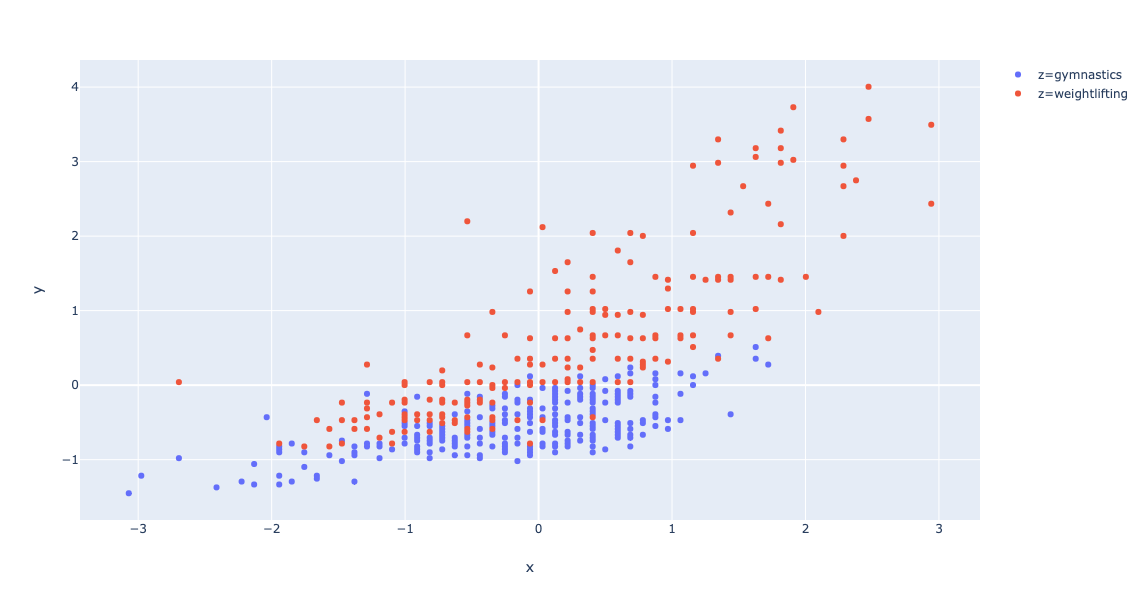

In [1295]:
px.scatter(pd.DataFrame({'x':X_[:,0],'y':X_[:,1],'z':Y}),x='x',y='y',color='z',height=600,width=800)

# LogisticRegressionCheck

In [1296]:
mod_logreg = LogisticRegression(solver='lbfgs',max_iter=10000)
mod_logreg.fit(X_,Y_)
print(np.mean(mod_logreg.predict(X_) == Y_))
mod_logreg.coef_, mod_logreg.intercept_

0.8774038461538461


(array([[ 1.76490432, -4.86365104]]), array([-0.41079031]))

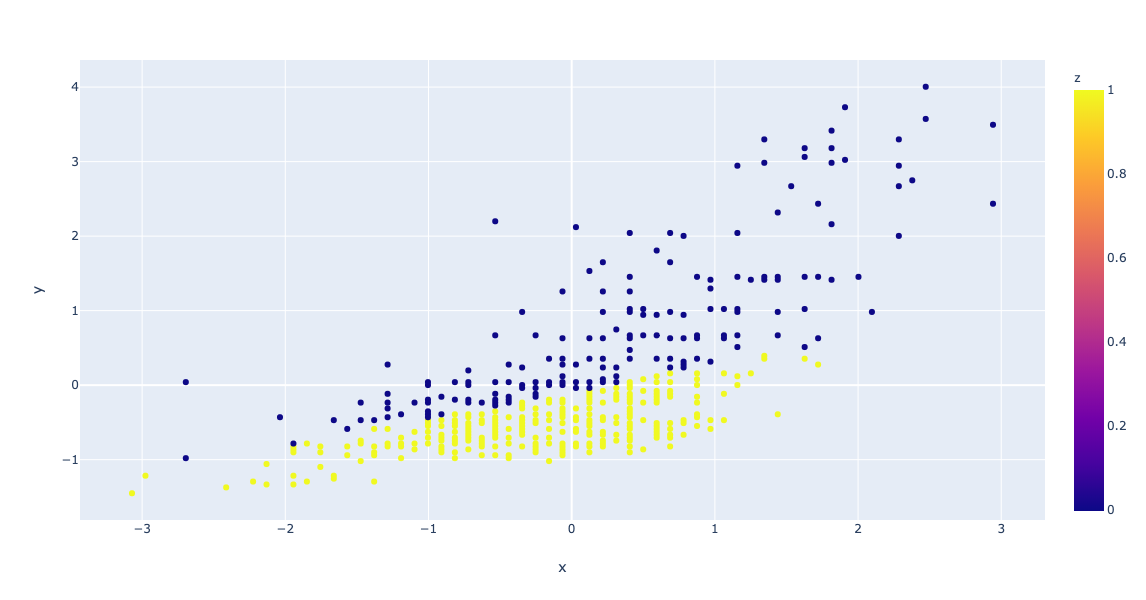

In [1297]:
px.scatter(pd.DataFrame({'x':X_[:,0],'y':X_[:,1],'z':mod_logreg.predict(X_)}),x='x',y='y',color='z',height=600,width=800)

# RandomForestCheck

In [1298]:
mod_rf = RandomForestClassifier(n_estimators=1,max_depth=3)#max_leaf_nodes=2)
#mod_rf = TreeClassifier(n_estimators=1)
mod_rf.fit(X,Y)
print(np.mean(mod_rf.predict(X) == Y))

0.6322115384615384


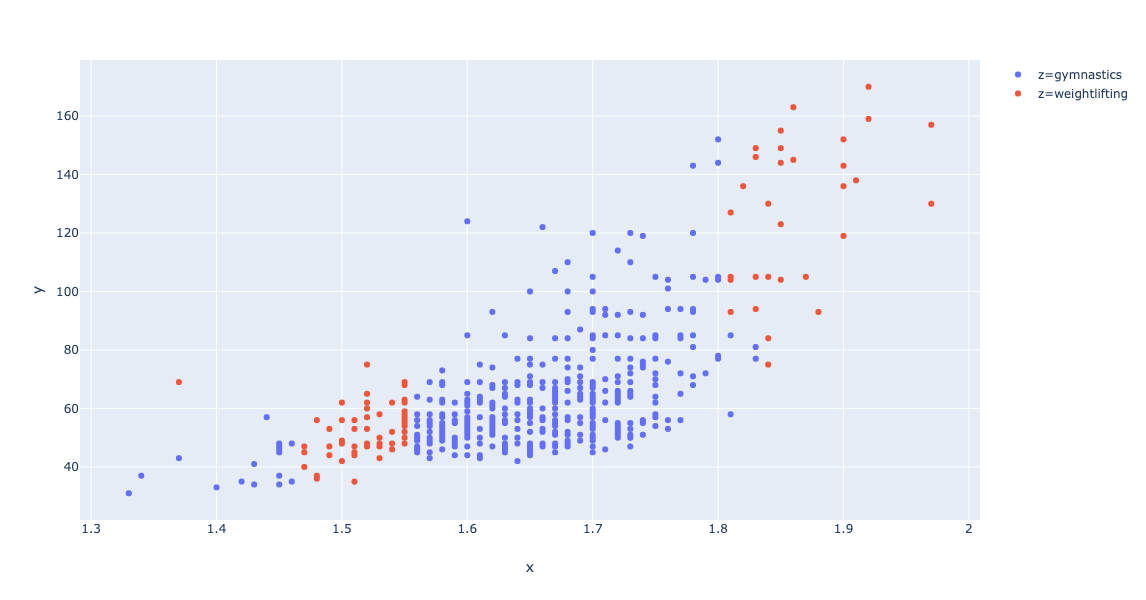

In [1299]:
px.scatter(pd.DataFrame({'x':X[:,0],'y':X[:,1],'z':mod_rf.predict(X)}),x='x',y='y',color='z',height=600,width=800)

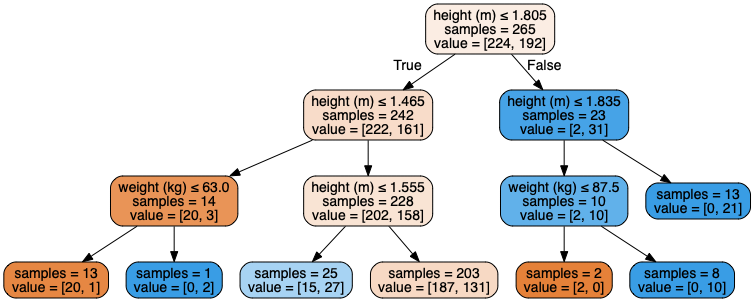

In [1300]:
feature_cols = ['height (m)','weight (kg)']

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()

dtree = mod_rf.estimators_[0]
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,impurity=False,proportion=False,
                special_characters=True,feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.set_size('"1000,10"')
graph.write_png('tmp.png')
Image(graph.create_png())

# Train Neural Network

In [1303]:
from jax import np

def sigmoid(x):
    #return 0.5 * (np.tanh(x / 2) + 1)
    return  ( 1/(1+np.exp(-x)) )*0.99998 + 0.00001

def relu(x):
    #return 0.5 * (np.tanh(x / 2) + 1)
    return  np.maximum(0.0,x)

def model(a,b):
    #return np.max(sigmoid(X_@a.T+b),1)
    return np.max(sigmoid(X_@a.T+b),1) #multi-dimensional
    #return sigmoid( np.max(X_@a.T+b,1) ) #multi-dimensional
    #return sigmoid(np.sum(relu(X_@a.T+b),1)) #multi-dimensional
    #return sigmoid(np.sum(X_@a.T+b,1)) #multi-dimensional
    #return sigmoid(X_@a.T+b)

# def model(a,b):
#     p = sigmoid(np.dot(X_,a)+b)
#     return p

def loss(a,b):
    p = model(a,b)
    #label_probs = p*Y_ + (1-p)*Y_
    #return -np.mean(np.log(label_probs))
    return -np.mean( (1-Y_)*np.log(1-p) + Y_*np.log(p) )

#grad_fun = jit(grad(logreg))
#perex_grads = jit(vmap(grad_fun, in_axes=(None, 0, 0)))  # fast per-example grads
loss_grad = jit(grad(loss,argnums=(0,1)))

100%|██████████| 2000/2000 [00:10<00:00, 183.83it/s]


[[ 2.6504304 -7.0422506]] [[-0.74670535]]
0.8822115659713745 0.8774038553237915


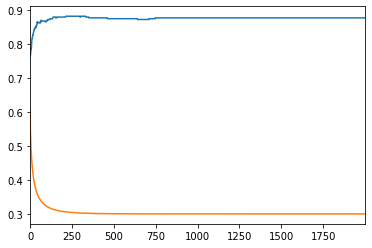

In [1306]:
#a = np.array([0.1,0.1])
#b = -1.0

#a = np.array([0.0,0.0])
#b = 0.0

#a = np.array(mod.coef_[0])
#b = float(mod.intercept_[0])

#a = np.array([[0.1,0.0],[0.0,0.1]])
#b = np.array([[0.0,0.0]])

#a = np.array([[0.1,0.0],[0.0,0.1],[0.0,0.0]])
#b = np.array([[0.0,0.0,0.1]])

a = np.array([[0.0,0.0]])
b = np.array([[0.0]])

max_eps = 1
min_eps = 1
epses = np.linspace(max_eps,min_eps,2000)

losses = list()
accuracies = list()

for eps in tqdm(epses):
    g = loss_grad(a,b)
    a = a - eps*g[0]
    b = b - eps*g[1]
    accuracies.append( float( np.mean( ( model(a,b) > 0.5 ) == Y_ )))
    losses.append(float(loss(a,b)))
print(a,b)
print(max(accuracies),accuracies[-1])
pd.Series(accuracies).plot()
pd.Series(losses).plot()

/opt/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4435: UserWarning:

Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.



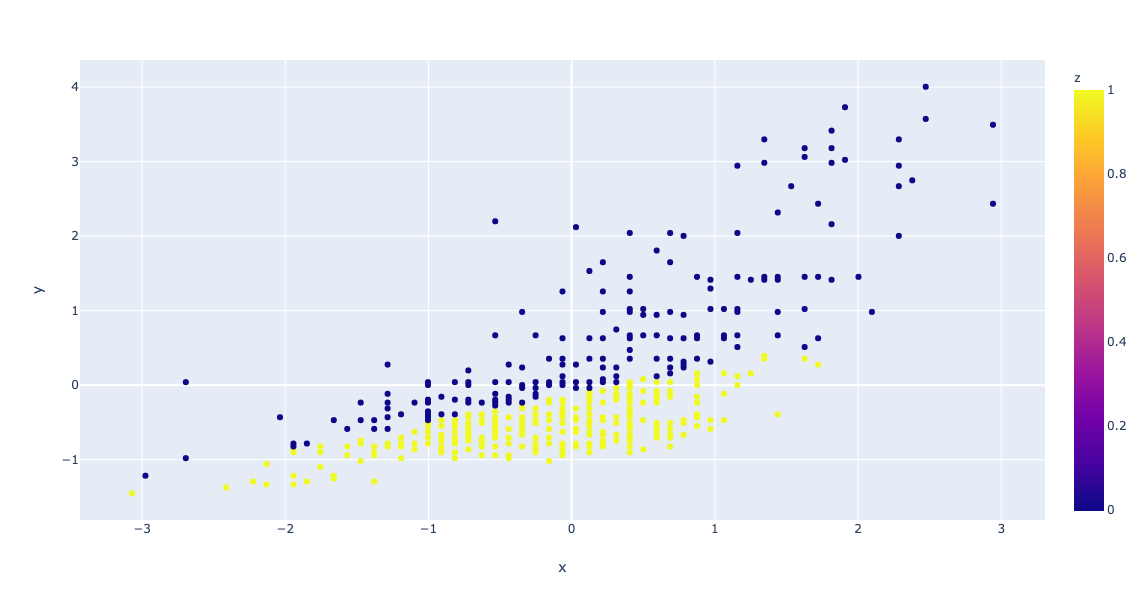

In [1307]:
px.scatter(pd.DataFrame({'x':X_[:,0],'y':X_[:,1],'z':( model(a,b) > 0.5 ).astype(int)}),x='x',y='y',color='z',height=600,width=600)